In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import joblib
import pickle
from PIL import Image
import tensorflow_hub as hub
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
import seaborn as sns
import glob
from tensorflow.keras import layers, models
import shutil

In [ ]:
tuberculosis_path = '/content/drive/MyDrive/College/SEM7/Honors/TB_Chest_Radiography_Database/Tuberculosis'
normal_path = '/content/drive/MyDrive/College/SEM7/Honors/TB_Chest_Radiography_Database/Normal'

session_tb_path = '/content/tuberculosis/'
session_normal_path = '/content/normal/'

os.makedirs(session_tb_path, exist_ok=True)
os.makedirs(session_normal_path, exist_ok=True)

for filename in os.listdir(tuberculosis_path):
    src_file = os.path.join(tuberculosis_path, filename)
    dst_file = os.path.join(session_tb_path, filename)
    shutil.copy2(src_file, dst_file)

for filename in os.listdir(normal_path):
    src_file = os.path.join(normal_path, filename)
    dst_file = os.path.join(session_normal_path, filename)
    shutil.copy2(src_file, dst_file)

In [ ]:
tuberculosis_path = '/content/tuberculosis'
normal_path = '/content/normal'

In [ ]:
input_path_tb = []
label_tb = []

for file in os.listdir(tuberculosis_path):
    file_path = os.path.join(tuberculosis_path, file)
    if os.path.isfile(file_path):
        input_path_tb.append(file_path)
        label_tb.append('positive')

tb_df = pd.DataFrame({'path': input_path_tb, 'label': label_tb})
tb_df.head()

path     label
0  /content/tuberculosis/Tuberculosis-362.png  positive
1  /content/tuberculosis/Tuberculosis-447.png  positive
2  /content/tuberculosis/Tuberculosis-629.png  positive
3   /content/tuberculosis/Tuberculosis-97.png  positive
4  /content/tuberculosis/Tuberculosis-687.png  positive

In [ ]:
input_path_normal = []
label_normal = []

for file in os.listdir(normal_path):
    file_path = os.path.join(normal_path, file)
    if os.path.isfile(file_path):
        input_path_normal.append(file_path)
        label_normal.append('negative')

normal_df = pd.DataFrame({'path': input_path_normal, 'label': label_normal})
normal_df.head()

path     label
0  /content/normal/Normal-3340.png  negative
1  /content/normal/Normal-3440.png  negative
2  /content/normal/Normal-2449.png  negative
3   /content/normal/Normal-609.png  negative
4  /content/normal/Normal-2687.png  negative

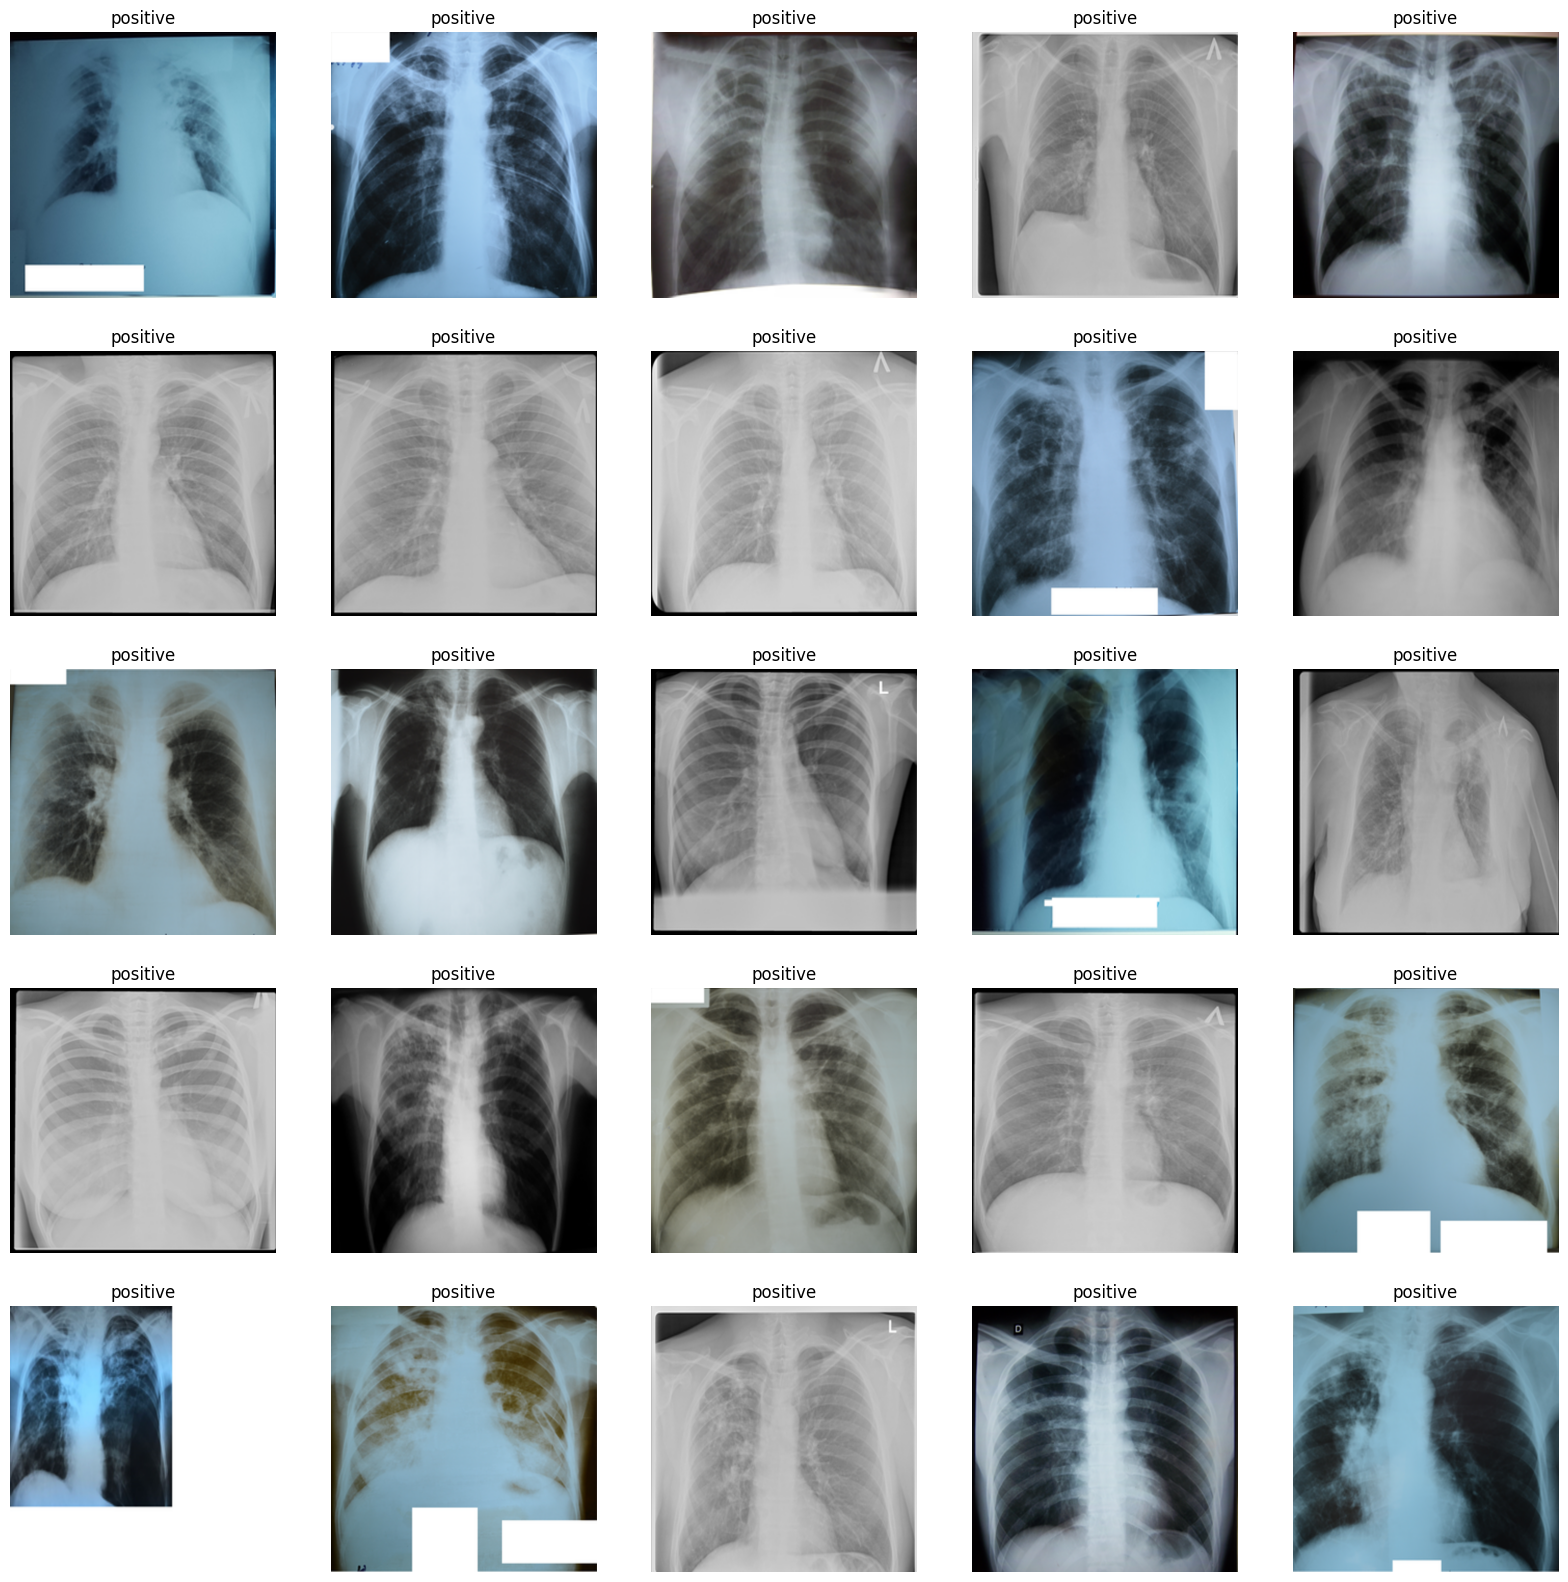

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(min(25, len(tb_df))):
    plt.subplot(5, 5, i + 1)
    img = cv2.imread(tb_df['path'][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(tb_df['label'][i])
plt.show()

In [ ]:
tb_df.shape

(700, 2)

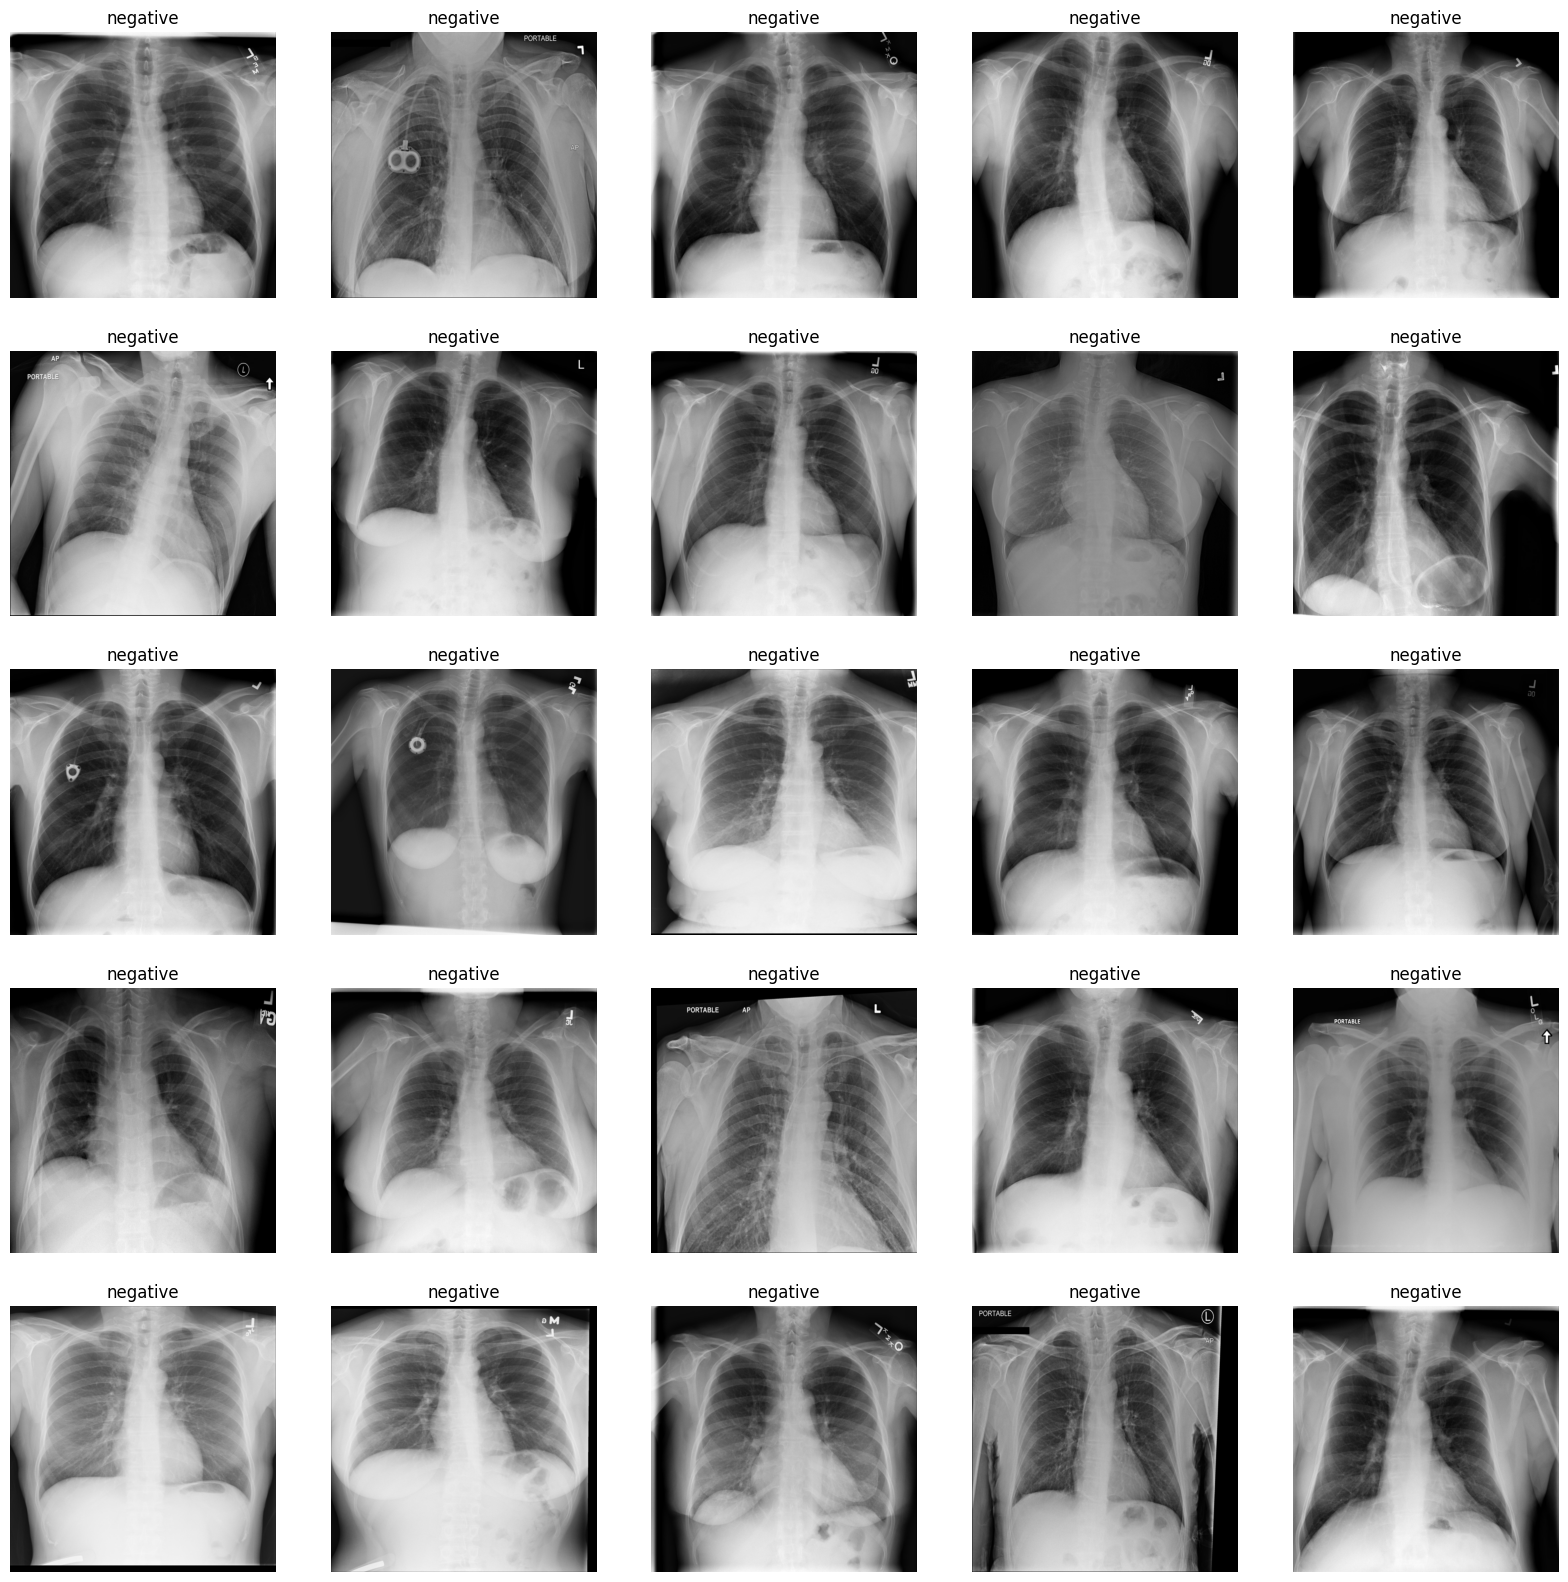

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(min(25, len(normal_df))):
    plt.subplot(5, 5, i + 1)
    img = cv2.imread(normal_df['path'][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(normal_df['label'][i])
plt.show()

In [ ]:
normal_df.shape

(3500, 2)

In [ ]:
combined_df = pd.concat([normal_df, tb_df], ignore_index=True)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df.head()

path     label
0  /content/normal/Normal-2171.png  negative
1  /content/normal/Normal-1443.png  negative
2  /content/normal/Normal-3470.png  negative
3   /content/normal/Normal-934.png  negative
4  /content/normal/Normal-1121.png  negative

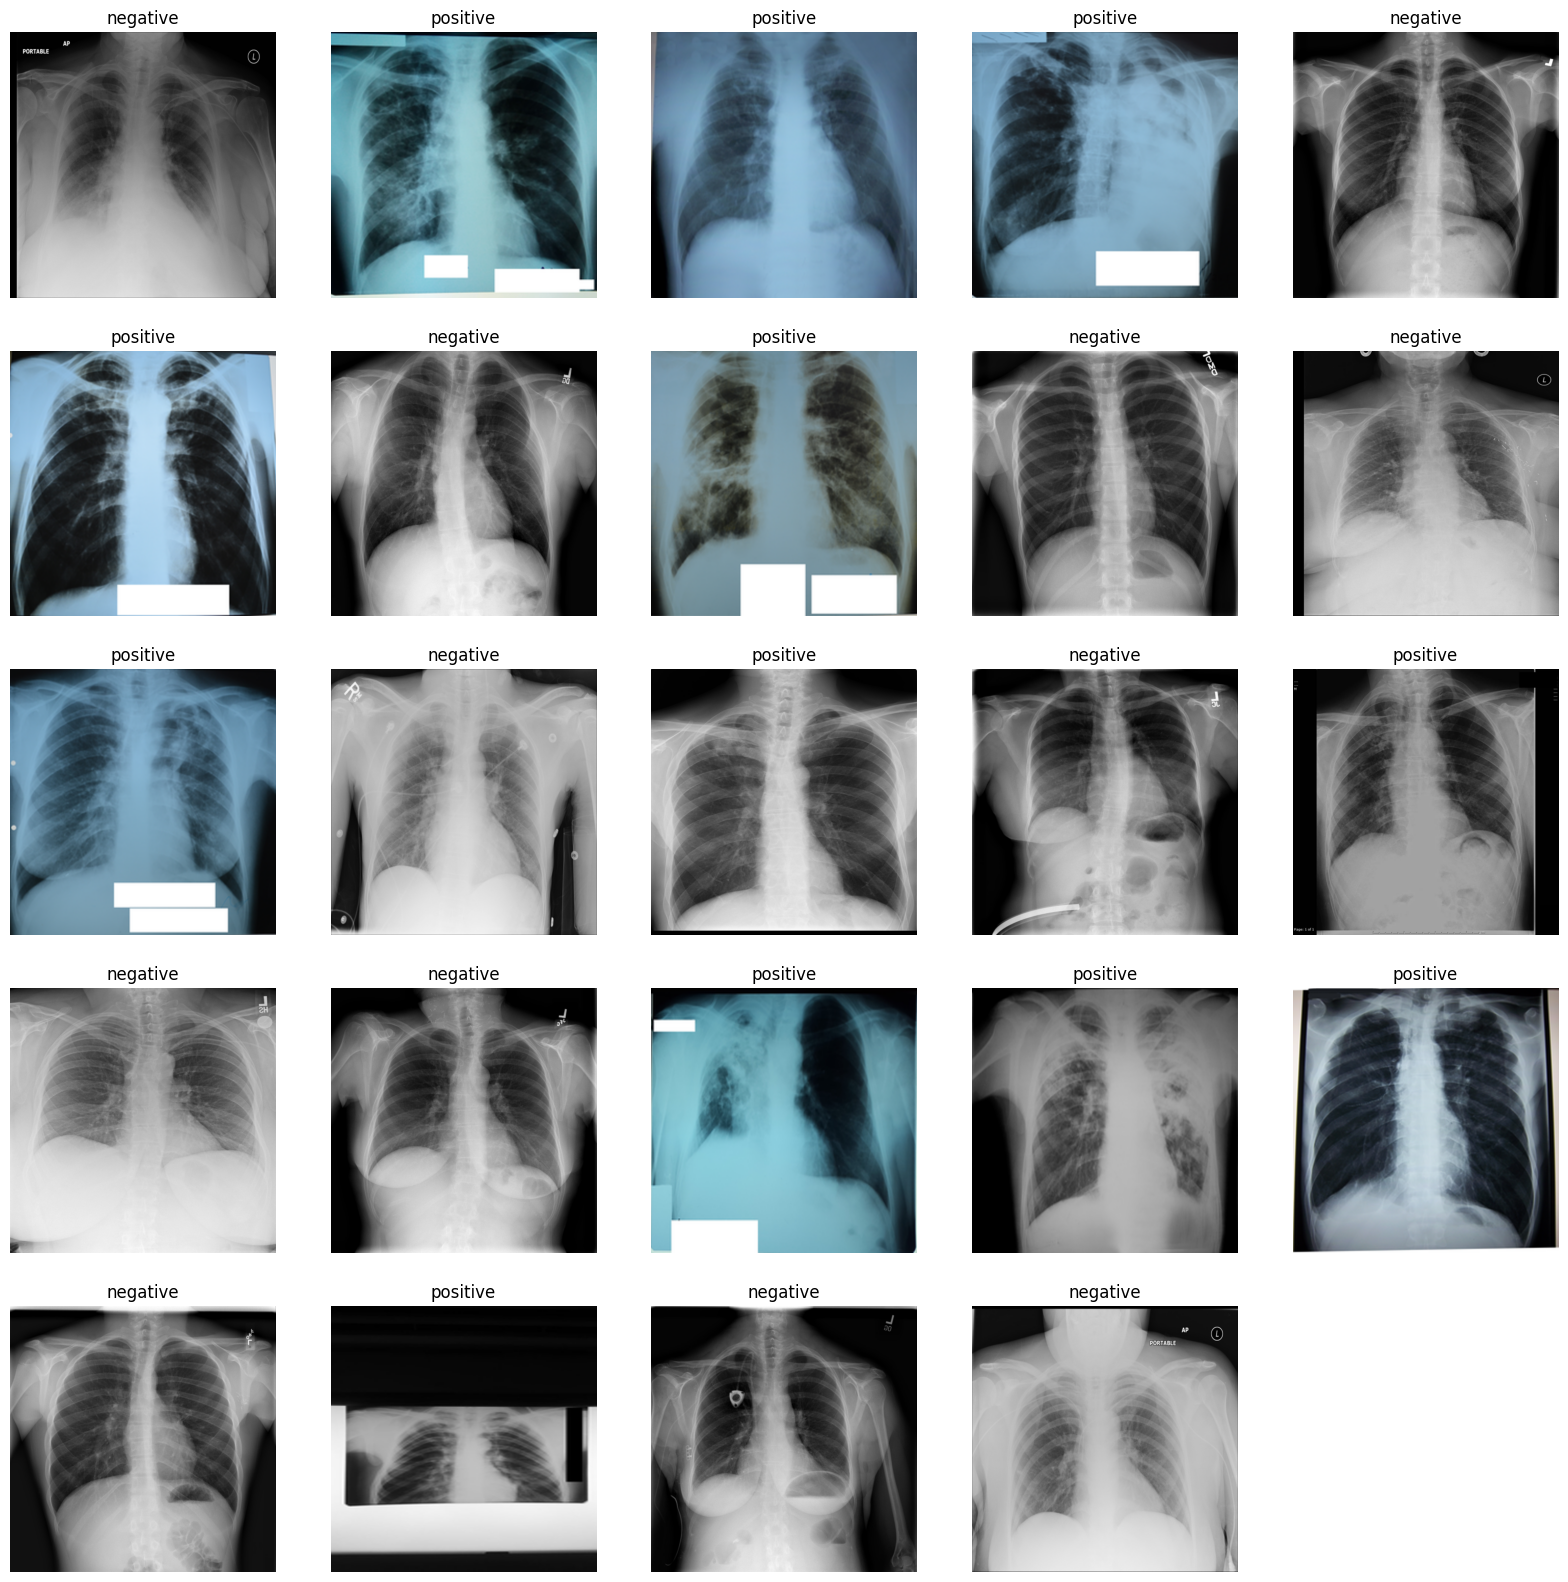

In [ ]:
# Select equal number of positive and negative images
num_samples = 12 # You can adjust this number as needed
positive_samples = combined_df[combined_df['label'] == 'positive'].sample(n=num_samples, random_state=42)
negative_samples = combined_df[combined_df['label'] == 'negative'].sample(n=num_samples, random_state=42)

# Combine and shuffle the samples
viz_df = pd.concat([positive_samples, negative_samples]).sample(frac=1).reset_index(drop=True)

plt.figure(figsize=(20, 20))
for i in range(min(25, len(viz_df))):
    plt.subplot(5, 5, i + 1)
    img = cv2.imread(viz_df['path'][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(viz_df['label'][i])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df['label'],
    random_state=42
)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 941 to 1599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    840 non-null    object
 1   label   840 non-null    object
dtypes: object(2)
memory usage: 19.7+ KB


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3360 entries, 2316 to 366
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    3360 non-null   object
 1   label   3360 non-null   object
dtypes: object(2)
memory usage: 78.8+ KB


In [ ]:
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagenerator = ImageDataGenerator(
    rescale=1./255
)

train_iterator = train_datagenerator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

test_iterator = test_datagenerator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)


Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.


In [ ]:
inputs = layers.Input(shape=(128, 128, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)  # 2 classes

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481,122 (17.09 MB)

 Trainable params: 4,481,122 (17.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get labels as array
labels = train_df['label'].values

# Compute class weights automatically
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(zip(np.unique(labels), class_weights))
print(class_weight_dict)


history = model.fit(
    train_iterator,
    validation_data=test_iterator,
    epochs=10,
    class_weight=class_weight_dict
)

{'negative': np.float64(0.6), 'positive': np.float64(3.0)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 64s 929ms/step - accuracy: 0.8188 - loss: 0.4545 - val_accuracy: 0.8798 - val_loss: 0.2731
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 730ms/step - accuracy: 0.8870 - loss: 0.2620 - val_accuracy: 0.9131 - val_loss: 0.1895
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 736ms/step - accuracy: 0.9081 - loss: 0.2448 - val_accuracy: 0.9262 - val_loss: 0.1743
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 730ms/step - accuracy: 0.9297 - loss: 0.1924 - val_accuracy: 0.9369 - val_loss: 0.1354
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 757ms/step - accuracy: 0.9399 - loss: 0.1494 - val_accuracy: 0.9619 - val_loss: 0.1291
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 786ms/step - accuracy: 0.9342 - loss: 0.1788 - val_accuracy: 0.9429 - val_loss: 0.1275
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 733ms/step - accuracy: 0.9536 - loss: 0.1476 - val_accuracy: 0.9702 - val_loss: 0.0953
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 722ms/step - accuracy: 0.9505 - loss: 0.1506 - val_accu

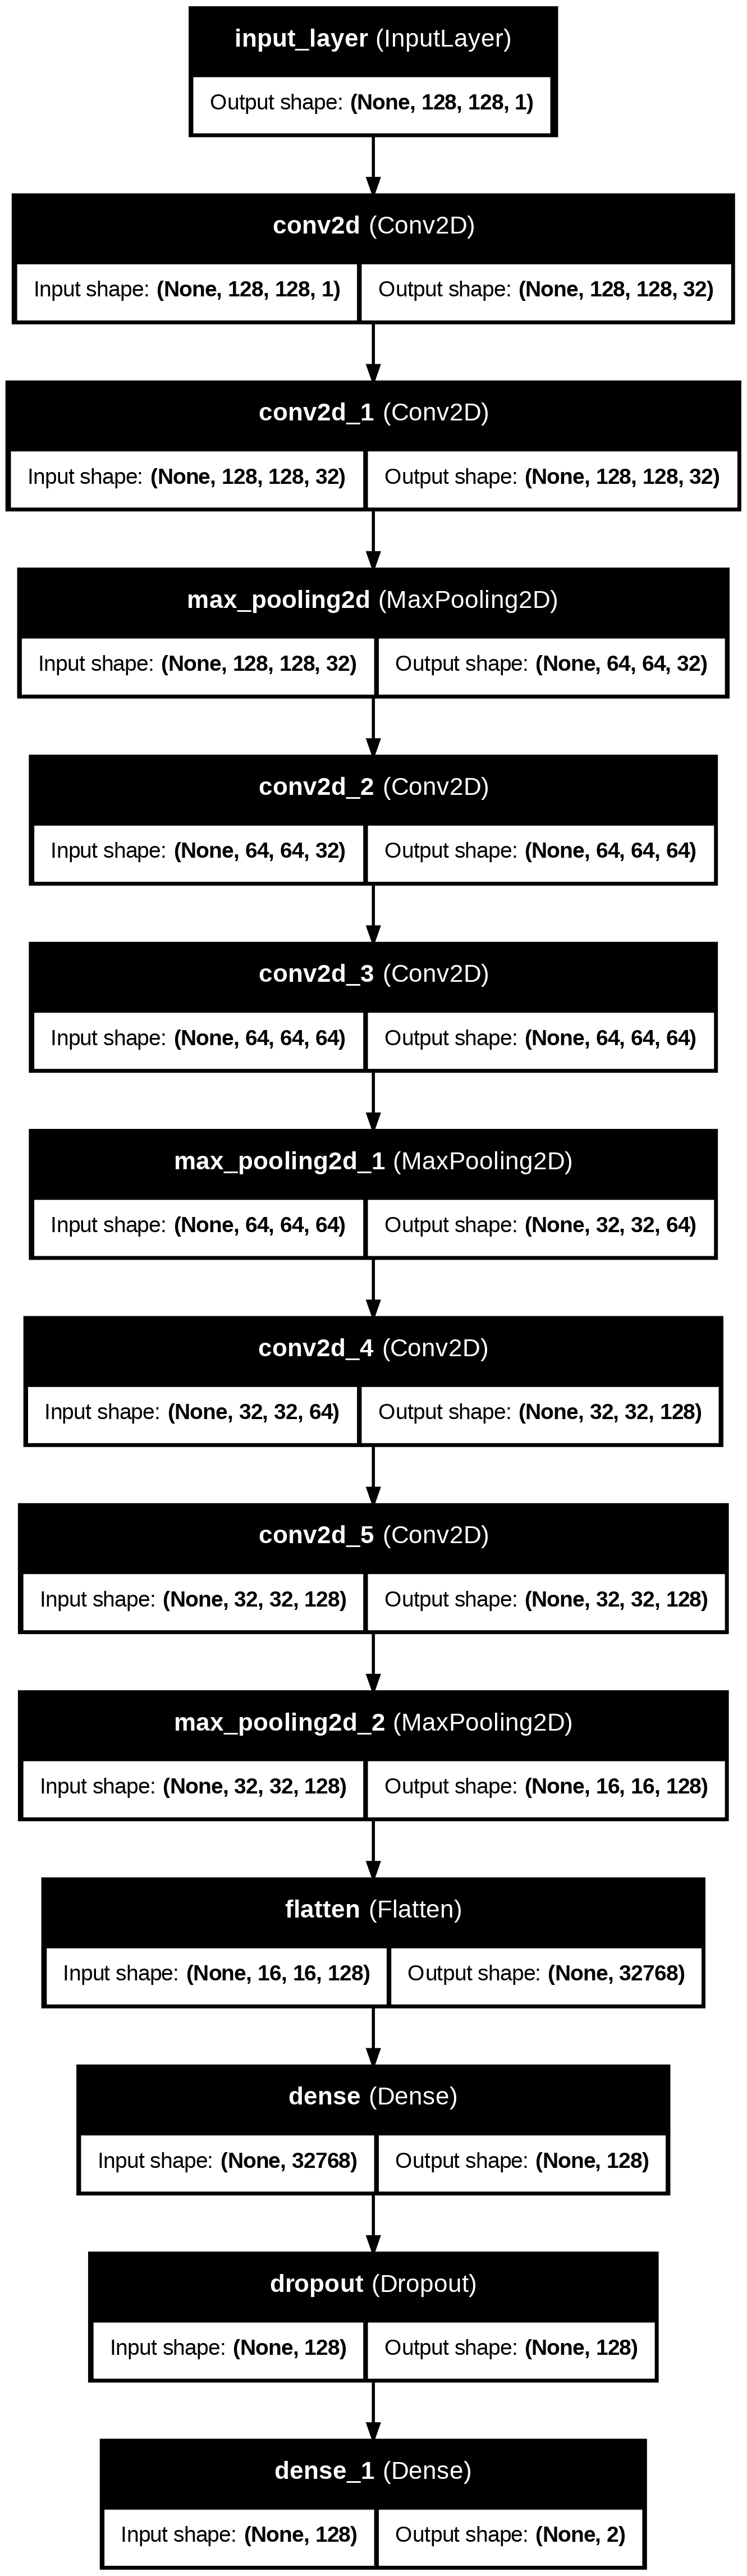

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 535ms/step


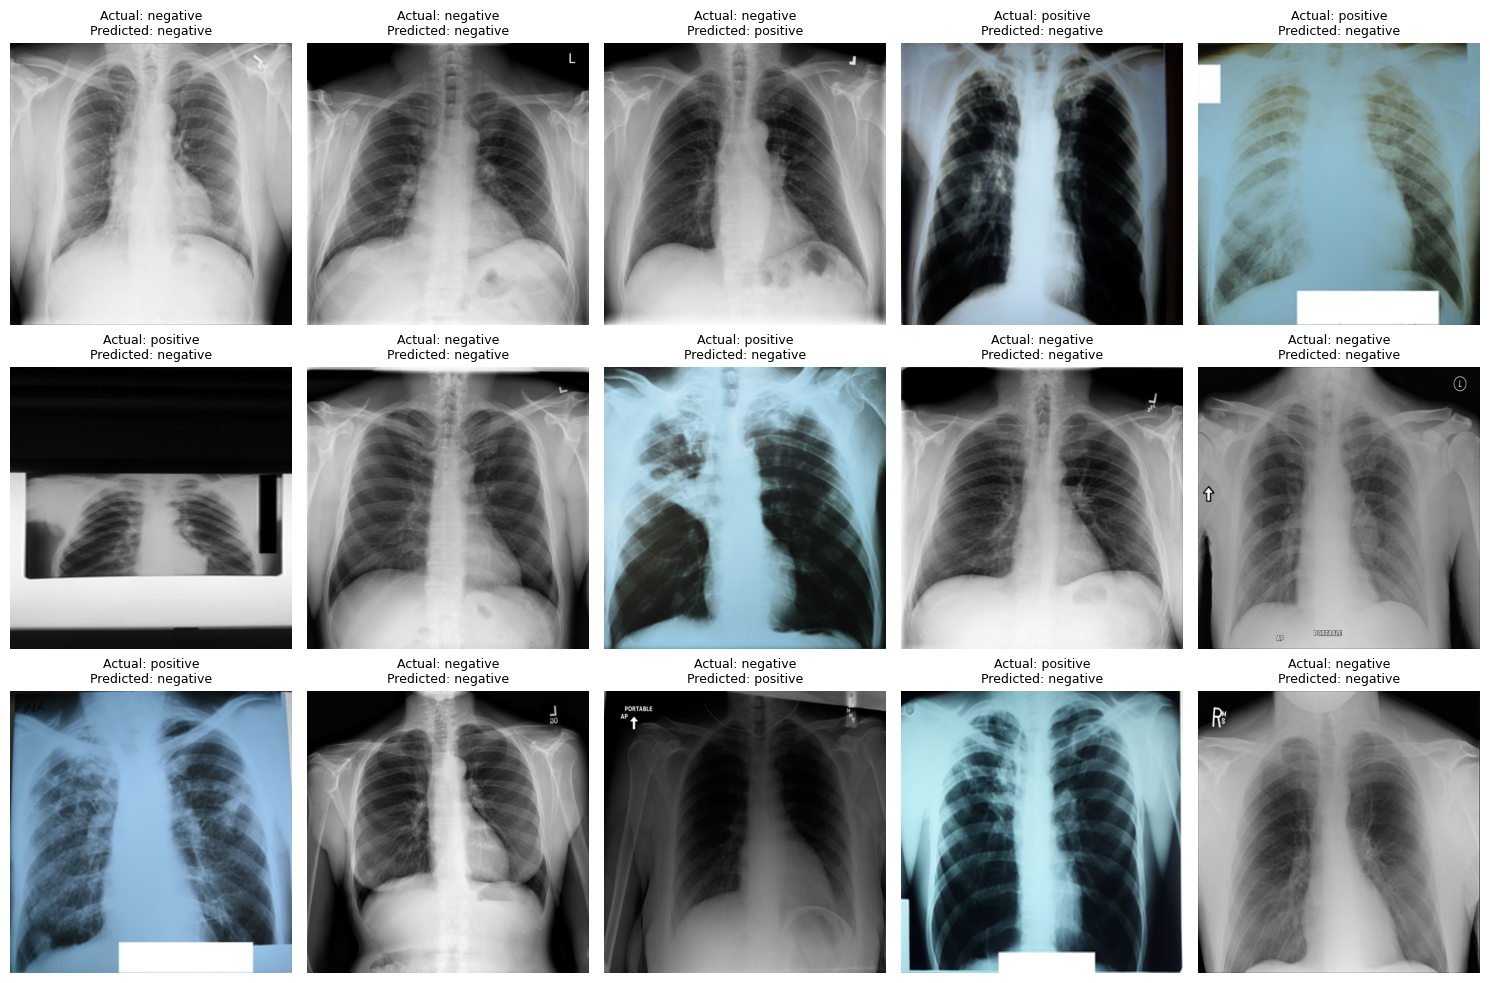

In [ ]:
class_labels = list(test_iterator.class_indices.keys())
test_iterator.reset()
pred_probs = model.predict(test_iterator, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_iterator.classes
filenames = test_iterator.filenames
plt.figure(figsize=(15, 10))
for i in range(15):
    idx = np.random.randint(0, len(filenames))
    img_path = test_iterator.filepaths[idx]
    img = plt.imread(img_path)
    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[pred_classes[idx]]
    plt.subplot(3, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Actual: {true_label}\nPredicted: {pred_label}", fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

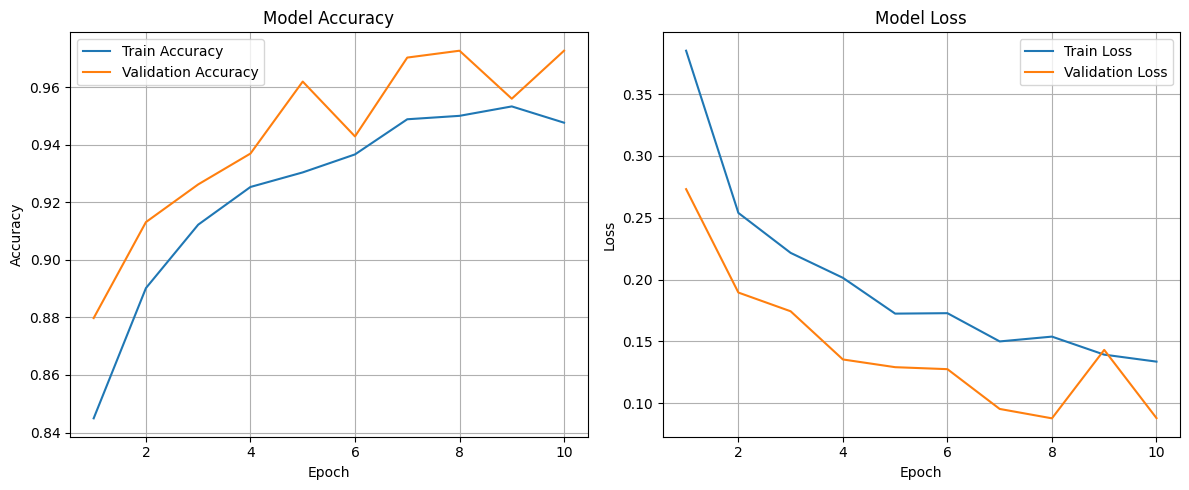

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


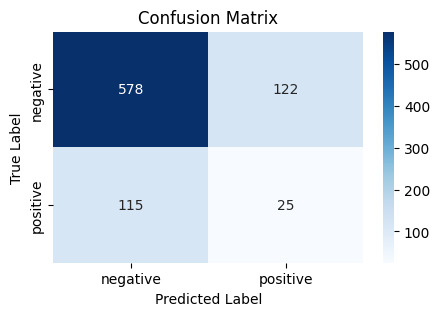

Classification Report:

              precision    recall  f1-score   support

    negative       0.83      0.83      0.83       700
    positive       0.17      0.18      0.17       140

    accuracy                           0.72       840
   macro avg       0.50      0.50      0.50       840
weighted avg       0.72      0.72      0.72       840



In [ ]:
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
report = classification_report(true_classes, pred_classes, target_names=class_labels)
print(report)

In [ ]:
model.save('best_model.h5')